Script Name: SZCGAT

Author: Fatemeh Delavari  
Original Version: (03/23/2025)
Version: 4.0 (05/05/2025)  
Description: Seizure type Classificaiton using Graph Attention Network

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
import os
import mne
import pickle

In [2]:
# Specify the folder path containing the EDF files
folder_path = 'C:/Users/Atena/Documents/edf_files'
# Specify the folder path containing the CSV files
folder_path_csv = 'C:/Users/Atena/Documents/csv_files'

In [ ]:
# define the functions to be used
def calculate_plv(phasedata):
    """
    Calculate the Phase Locking Value (PLV) between pairs of EEG channels.
    
    Parameters:
    eeg_data (ndarray): EEG data of shape (n_channels, n_times)
    sfreq (float): Sampling frequency of the EEG data
    low_freq (float): Lower frequency bound for band-pass filter (default 8 Hz)
    high_freq (float): Upper frequency bound for band-pass filter (default 13 Hz)
    
    Returns:
    plv_matrix (ndarray): PLV matrix of shape (n_channels, n_channels)
    """
    n_channels, n_times = phasedata.shape
    plv_matrix = np.ones((n_channels, n_channels))
    plv_array = np.ones((round(n_channels*(n_channels - 1)/2)))
    
    k = 0
    # Calculate PLV
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            phase_diff = phasedata[i] - phasedata[j]
            plv = np.abs(np.sum(np.exp(1j * phase_diff)) / n_times)
            plv_matrix[i, j] = plv
            plv_matrix[j, i] = plv  # PLV is symmetric
            plv_array[k] = plv
            k = k + 1
    return plv_array, plv_matrix

from scipy.signal import hilbert, butter, filtfilt
def bandpass_filter(data, sfreq, low_freq, high_freq):
    """
    Band-pass filter the data.
    
    Parameters:
    data (ndarray): The input signal of shape (n_channels, n_times)
    sfreq (float): The sampling frequency
    low_freq (float): The lower bound of the frequency range
    high_freq (float): The upper bound of the frequency range
    
    Returns:
    filtered_data (ndarray): The band-pass filtered signal
    """
    nyquist = 0.5 * sfreq
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

def epoch_data(data, sfreq, epoch_length):
    n_channels, n_samples = data.shape
    epoch_samples = int(epoch_length * sfreq)
    n_epochs = n_samples // epoch_samples
    epochs = np.array_split(data[:, :n_epochs * epoch_samples], n_epochs, axis=1)
    return epochs, n_epochs

In [12]:
# Define the parameters, constants, and variables
electrode_locations = {
    'FP1': (-0.3, 0.8),
    'FP2': (0.3, 0.8),
    'F7': (-0.7, 0.5),
    'F3': (-0.4, 0.4),
    'FZ': (0.0, 0.3),
    'F4': (0.4, 0.4),
    'F8': (0.7, 0.5),
    'T3': (-0.8, 0),
    'C3': (-0.5, 0.0),
    'CZ': (0.0, 0.0),
    'C4': (0.5, 0.0),
    'T4': (0.8, 0),
    'T5': (-0.6, -0.5),
    'P3': (-0.4, -0.4),
    'PZ': (0.0, -0.3),
    'P4': (0.4, -0.4),
    'T6': (0.6, -0.5),
    'O1': (-0.3, -0.8),
    'O2': (0.3, -0.8)
    }

In [ ]:
# Load data and lables for a balanced subset of 4 seizure types (GN, FN, CP, AB)
# Balanced subset: Only the data as long as the shortest class (AB) is used
with open('xd1s4.pkl', 'rb') as f:
    xd = pickle.load(f)

with open('yl1s4.pkl', 'rb') as f:
    yl = pickle.load(f)

In [7]:
xd.shape

(560, 19, 250)

In [8]:
yl.shape

(560,)

In [10]:
from scipy.stats import kurtosis

# === Feature Extraction per Channel ===
def extract_features(channel_signal):
    return np.array([
        np.mean(channel_signal),
        np.std(channel_signal),
        np.max(channel_signal),
        np.min(channel_signal),
        np.median(channel_signal),
        np.percentile(channel_signal, 75) - np.percentile(channel_signal, 25),  # IQR
        # kurtosis(channel_signal, fisher=True),
        # np.mean(channel_signal**2)
    ])

In [ ]:
frequency_bands = {
        "Theta": [4, 8]
    }
eeg_data = xd
sfreq = 250  # Sampling frequency
epoch_length = 1  # Length of each epoch in seconds
# PLV
adj_matrices = []
for i in range(eeg_data.shape[0]):
    freq_num = 0
    for band, freq_range in frequency_bands.items():
        freq_num = freq_num + 1
        low_freq, high_freq = freq_range
        # for repnum in range(4):
        eeg_data_filtered = bandpass_filter(eeg_data[i], sfreq, low_freq, high_freq)
        # Compute the analytic signal (Hilbert transform) to get the phase
        analytic_signal = hilbert(eeg_data_filtered, axis=1)
        phase_data = np.angle(analytic_signal)
        phase_epochs, n_epochs  = epoch_data(phase_data, sfreq, epoch_length)
        plv_array = np.zeros((19*9, n_epochs, high_freq-low_freq+1))
        plv_matrix = np.zeros((19, 19, n_epochs, high_freq-low_freq+1))
        for freq in range(low_freq, high_freq+1):
            freq_n = freq-low_freq
            eeg_data_filtered = bandpass_filter(eeg_data[i], sfreq, freq-1, freq+1)
            # Compute the analytic signal (Hilbert transform) to get the phase
            analytic_signal = hilbert(eeg_data_filtered, axis=1)
            phase_data = np.angle(analytic_signal)
            phase_epochs, n_epochs = epoch_data(phase_data, sfreq, epoch_length)
            epoch_n = 0
            for epoch in phase_epochs:
                plv_array[:, epoch_n, freq_n], plv_matrix[:, :, epoch_n, freq_n] = calculate_plv(epoch)
                epoch_n = epoch_n + 1
        plv_all = np.mean(plv_array, axis = 2)
        plv_all_matrix = np.mean(plv_matrix, axis = 3)
    adj_matrix = np.mean(plv_all_matrix, axis = 2)
    adj_matrix[adj_matrix < 0.7] = 0  # Threshold weak connections
    adj_matrix[adj_matrix > 0.7] = 1
    adj_matrices.append(adj_matrix)

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.model_selection import train_test_split

# === Helper: Convert adjacency to edge_index ===
def adjacency_to_edge_index(adj_matrix):
    edge_index = np.array(np.nonzero(adj_matrix))
    return torch.tensor(edge_index, dtype=torch.long)

# === GAT Model ===
class EEG_GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, num_classes, heads=4):
        super(EEG_GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_dim, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False)
        self.classifier = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pool node features to graph level
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

Epoch 0: Train Loss = 1.4013, Test Acc = 0.2232
Epoch 10: Train Loss = 1.3870, Test Acc = 0.2232
Epoch 20: Train Loss = 1.3867, Test Acc = 0.2232
Epoch 30: Train Loss = 1.3925, Test Acc = 0.2232
Epoch 40: Train Loss = 1.3900, Test Acc = 0.2500
Epoch 50: Train Loss = 1.3772, Test Acc = 0.4018
Epoch 60: Train Loss = 1.2626, Test Acc = 0.2946
Epoch 70: Train Loss = 0.9941, Test Acc = 0.4464
Epoch 80: Train Loss = 0.9271, Test Acc = 0.6339
Epoch 90: Train Loss = 0.7638, Test Acc = 0.6429
Epoch 100: Train Loss = 0.7411, Test Acc = 0.7232
Epoch 110: Train Loss = 0.6401, Test Acc = 0.7143
Epoch 120: Train Loss = 0.6500, Test Acc = 0.8482
Epoch 130: Train Loss = 0.6322, Test Acc = 0.8393
Epoch 140: Train Loss = 0.5984, Test Acc = 0.7500
Epoch 150: Train Loss = 0.6203, Test Acc = 0.8393
Epoch 160: Train Loss = 0.7075, Test Acc = 0.7232
Epoch 170: Train Loss = 0.6453, Test Acc = 0.6250
Epoch 180: Train Loss = 0.5376, Test Acc = 0.6786
Epoch 190: Train Loss = 0.6295, Test Acc = 0.8839
Epoch 200: 

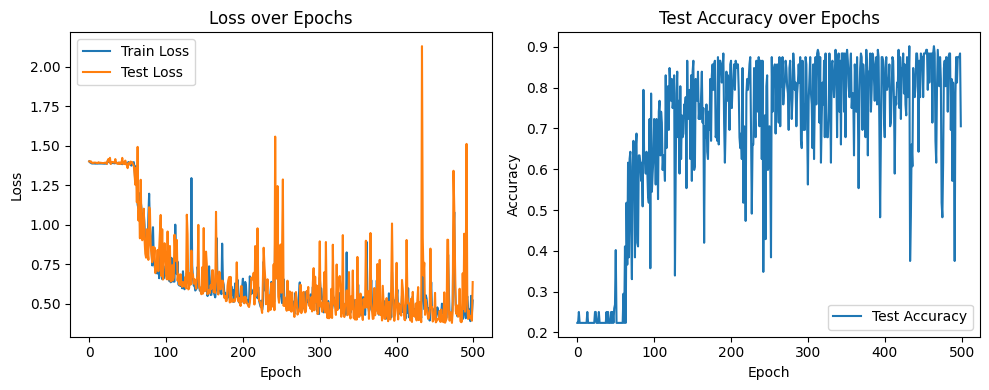

In [15]:
# === Main Pipeline ===
def main():
    # Simulated EEG input: (samples, channels, time points)
    eeg_data = xd
    labels = yl
    connectivity_matrices = adj_matrices
    
    all_graphs = []
    for i in range(len(eeg_data)):
        sample = eeg_data[i]
        label = labels[i]
        conn_matrix = connectivity_matrices[i]

        # --- Extract node features for this sample (e.g., mean, std, max, etc.)
        x = np.array([extract_features(ch) for ch in sample])  # shape: (19, 6)              
        x = torch.tensor(x, dtype=torch.float)

        # --- Use precomputed connectivity
        edge_index = adjacency_to_edge_index(conn_matrix)

        # --- Create graph
        graph = Data(x=x, edge_index=edge_index, y=torch.tensor(label, dtype=torch.long))
        all_graphs.append(graph)

    # === Train/test split ===
    train_idx, test_idx = train_test_split(np.arange(len(all_graphs)), test_size=0.2, random_state=42)
    train_graphs = [all_graphs[i] for i in train_idx]
    test_graphs = [all_graphs[i] for i in test_idx]

    train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=16)

    # === Model, optimizer ===
    num_classes = len(np.unique(labels))  # Automatically detect number of classes
    model = EEG_GAT(in_channels=6, hidden_dim=32, num_classes=num_classes, heads=4)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # === Training Loop ===
    train_losses, test_losses, test_accuracies = [], [], []
    for epoch in range(500):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            # loss = F.nll_loss(out, batch.y, weight=class_weights)
            loss = F.nll_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # === Evaluation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in test_loader:
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = F.nll_loss(out, batch.y)
                pred = out.argmax(dim=1)
                correct += (pred == batch.y).sum().item()
                total += batch.num_graphs
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Test Acc = {correct/total:.4f}")

    # === Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()